In [55]:
#Benjamin Schreyer benontheplanet@gmail.com

#TODO:
#RungeKutta aribtrary precision in compiled language

#Analytic result for the uniform cross section silica flexure:
#10^sqrt(9.81*20/pi*2/(0.2*10^-3)**4/73/10**9)*1/2.3 = 10^450 growth
#1m flexure, 73gpa fused silica, ln(1) = 2.3, g = 9.81m/s/s, m = 20kg, r = 0.2mm

import matplotlib.pyplot as plt
from mpmath import mpmathify
import mpmath as mp
import numpy as np
import math
import time
from scipy.optimize import curve_fit
from functions_bending_schreyer import *
plt.rcParams.update({'font.size': 22})
plt.rcParams['font.weight'] = 'bold'
###
### Need to look at Green's function iteration methods, it seems like this could work, certainly
### for the case of constantI(s)

#https://www.johndcook.com/blog/2020/02/13/runge-kutta-methods/
#https://nodepy.readthedocs.io/en/latest/modules/runge_kutta_method.html#nodepy.runge_kutta_method.DC
#https://ntrs.nasa.gov/api/citations/19710018627/downloads/19710018627.pdf

In [16]:
theta_test = [3]

cos_test = [False]
F_test = [15*9.81]

N = 0
T = 0
N_Passed = 0
thet = theta_test[0]
cos = False
Fs = F_test[0]

#Cosine only bending demo
tol =  mpmathify(0.001)
Sf = mpmathify(0.6)  #600mm
S = mpmathify(0.6)
E = mpmathify("73E9")
#To find a bending of angle theta:
#If F is zero, do a search on F2
#If F is nonzero and F2 is zero do a search on M0
#If both F and F2 are nonzero do a search on F2


N = 1000
#Define geometry of the flexure
def If(s):
    return np.pi / 4* (.2 * 10**-3)**4 * (np.zeros(s.shape) + 1)

def I(s):
    return mpmathify(If(float(s)))

grid = mp.matrix(np.linspace(0,Sf,N))
#print(grid)
#print(grid[len(grid) - 1],"GRID last entry")
Isamples = mp.matrix(If(np.linspace(0,Sf,N)))
#floating precision
mp.dps = 40



Ti = time.time_ns()
Sa, Fa, Esa = bend_samples(grid, Isamples, order = 4, E = E, Fsin = mpmathify(Fs), Fcos = cos, theta0 = mpmathify(thet), tol = tol)
Tf = time.time_ns()




using anderson method
m: 0.0429290368259155934712
x:     7.27170032626959138647e-330
error: 2.98329886717488623824e-329
m: 0.0429290368259155934712
x:     7.56925593736325058775e-330
error: 1.45434006525391827729e-329
m: 0.0429290368259155934712
x:     2.03530410605481441262e-330
error: 1.39482894303518643704e-329
m: 0.632620382748969195044
x:     9.73834597382867670707e-331
error: 2.88038576773499202008e-330
m: 0.632620382748969195044
x:     1.11796543365158889844e-330
error: 7.57446750391098536257e-331
m: 0.632620382748969195044
x:     8.91755045998605856745e-331
error: 4.6918507785365608079e-331
m: 0.993057591115524906615
x:     8.90070710412877184429e-331
error: 1.67643025476899973985e-332
m: 0.993057591115524906615
x:     8.96756771672014621143e-331
error: 1.3395631376232652767e-332
m: 0.993057591115524906615
x:     8.96745017300286307984e-331
error: 2.3508857957779339982e-335
[8.96745017300286e-331]
[                  0.0]
[                  0.0] True False


In [17]:
Faa = mp.matrix([[x[0],x[1],x[2]] for x in Fa])


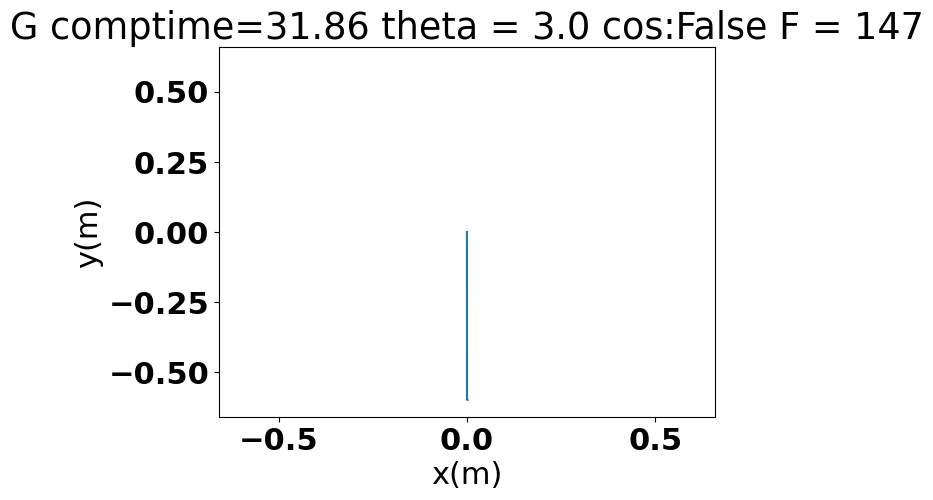

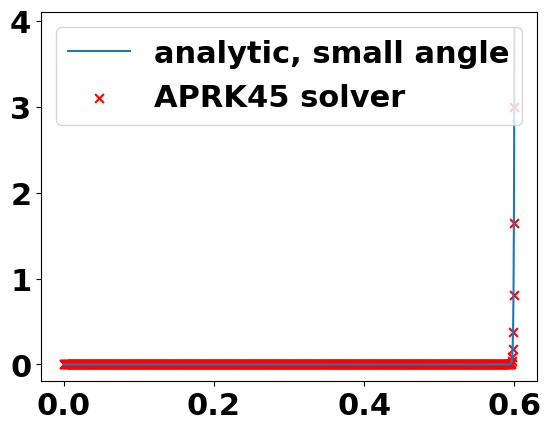

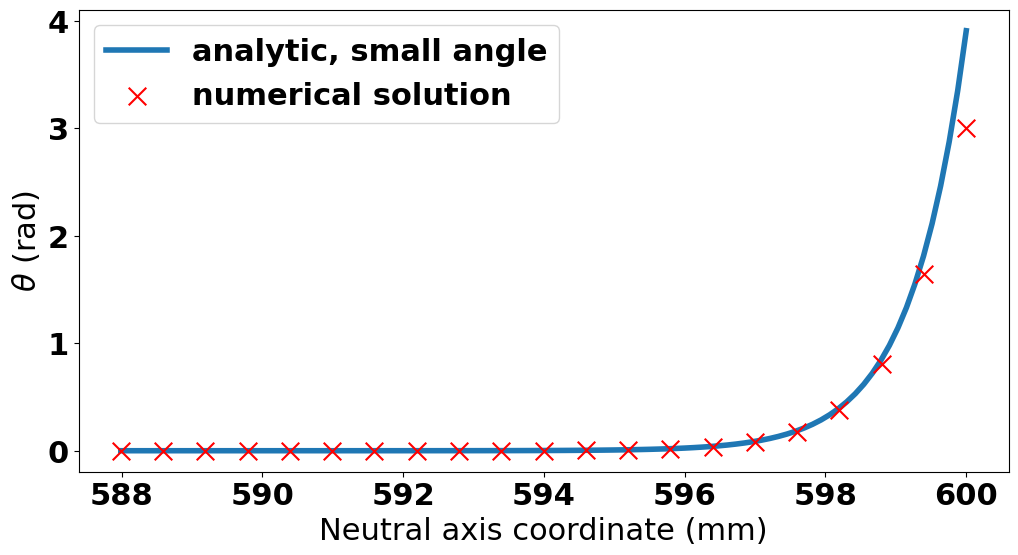

In [18]:
S = np.array(Sa, dtype = "float")
F = np.array(Fa, dtype = "float")
Es = np.array(Esa, dtype = "float")
#print(len(F))
#plt.plot(S,F[:,-2])
#plt.title("Angle over the fiber")
#plt.show()
#plt.title("Error")
#plt.plot(S,Es[:,-2])


xs,zs = integrate_xz([x[1] for x in list(F)],S)
#plot limits to give perceived geometry
lm = [-1.1*np.max([np.max(np.abs(xs)),np.max(np.abs(zs))]),1.1*np.max([np.max(np.abs(xs)),np.max(np.abs(zs))])]

plt.xlim(lm)
plt.ylim(lm)
plt.plot(xs,zs)
#Small total angle error and tolerance for end angle met?
PASSED = np.sum(np.abs(Es[:,-2])) < thet * tol and  np.sum(np.abs(Es[:,-2])) < 0.015 and np.abs(F[-1,-2] - mpmathify(thet))/ mpmathify(thet) < tol

T += (Tf-Ti)/10**9
N +=1
if PASSED:
    N_Passed += 1
    PASSED = "G"
else:
    PASSED = "X"
plt.title(PASSED+ " comptime="+str(round((Tf-Ti)/10**9,2))+" theta = " + str(round(F[-1][-2],5)) + " cos:" + str(cos) + " F = " + str(round(Fs)) )
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.show()

FLOG =((Faa)[1:,1])#)ov( mp.ln,
#print(FLOG)

def linear_model(S, intercept):
    return np.sqrt(If(np.array([0.5]))[0]**-1 * 9.81*15 /73/10**9) * S + intercept

# Perform curve fitting to find intercept
popt, _ = curve_fit(linear_model, S[1:], ov(mp.ln,FLOG[:]), p0=[0])  # Initial guess for intercept = 0
cfit = popt[0]
#plt.ylim(0,0.0001)

np.savetxt("C_numeric_F.txt",FLOG)
np.savetxt("C_numeric_S.txt",S)
np.savetxt("C_analytic_S.txt",np.linspace(S[979],0.6,100))
np.savetxt("C_analytic_F.txt", np.exp((np.sqrt(If(np.array([0.5]))[0]**-1 * 9.81*15 /73/10**9)) * np.linspace(S[979],0.6,100)+cfit))
plt.plot(S,np.exp((np.sqrt(If(np.array([0.5]))[0]**-1 * 9.81*15 /73/10**9)*S)+cfit), label = "analytic, small angle")
plt.scatter(S[1::],FLOG[::],label=("APRK45 solver"), c = 'r', s= 40, marker = 'x')
#plt.scatter(S,np.log(F[:,2]))

plt.legend()
plt.show()
plt.figure(figsize=(12,6))
plt.title("")
plt.ylabel(r"$\theta$ (rad)")
plt.xlabel("Neutral axis coordinate (mm)")
plt.plot(1000*np.linspace(S[979],0.6,100),np.exp((np.sqrt(If(np.array([0.5]))[0]**-1 * 9.81*15 /73/10**9)) * np.linspace(S[979],0.6,100)+cfit), label = "analytic, small angle",linewidth = 4,zorder = -100)
plt.scatter(1000*S[979::1],FLOG[978::1],label=("numerical solution"), c = 'r', s= 160, marker = 'x',zorder = 100)

np.savetxt("numerical_s.txt",S[979::1])
np.savetxt("numerical_theta.txt",FLOG[978::1])

np.savetxt("analytic_s.txt",np.linspace(S[979],0.6,100))
np.savetxt("analytic_theta.txt",np.exp((np.sqrt(If(np.array([0.5]))[0]**-1 * 9.81*15 /73/10**9)) * np.linspace(S[979],0.6,100)+cfit))

#plt.scatter(S,np.log(F[:,2]))


plt.legend()
plt.savefig("methods_comparison.png")
plt.show()


In [19]:
theta_test = [0.017]

cos_test = [False]
F_test = [15*9.81]

N = 0
T = 0
N_Passed = 0
thet = theta_test[0]
cos = False
Fs = F_test[0]

#Cosine only bending demo
tol =  mpmathify(0.001)
Sf = mpmathify(0.6)  #600mm
S = mpmathify(0.6)
E = mpmathify("73E9")
#To find a bending of angle theta:
#If F is zero, do a search on F2
#If F is nonzero and F2 is zero do a search on M0
#If both F and F2 are nonzero do a search on F2


N = 1000
#Define geometry of the flexure
def If(s):
    return np.pi / 4* (.2 * 10**-3)**4 * (np.zeros(s.shape) + 1)

def I(s):
    return mpmathify(If(float(s)))

grid = mp.matrix(np.linspace(0,Sf,N))
#print(grid)
#print(grid[len(grid) - 1],"GRID last entry")
Isamples = mp.matrix(If(np.linspace(0,Sf,N)))
#floating precision
mp.dps = 40



Ti = time.time_ns()
Sa, Fa, Esa = bend_samples(grid, Isamples, order = 4, E = E, Fsin = mpmathify(Fs), Fcos = cos, theta0 = mpmathify(thet), tol = tol)
Tf = time.time_ns()




using anderson method
m: 0.999743951473758679249
x:     2.06697736185618996723e-333
error: 1.69053602473243554024e-331
m: 0.999743951473758679249
x:     4.11304919980732413384e-333
error: 4.13395472371237993446e-333
m: 0.999743951473758679249
x:     4.09214872082222501973e-333
error: 4.18110478101116012414e-335
canceled with z = 4.09215376574030765794e-333
x:     4.09215376574030765794e-333
error: 1.00898399133730199633e-338
[4.09215376574031e-333]
[                  0.0]
[                  0.0] True False


In [20]:
Faa = mp.matrix([[x[0],x[1],x[2]] for x in Fa])

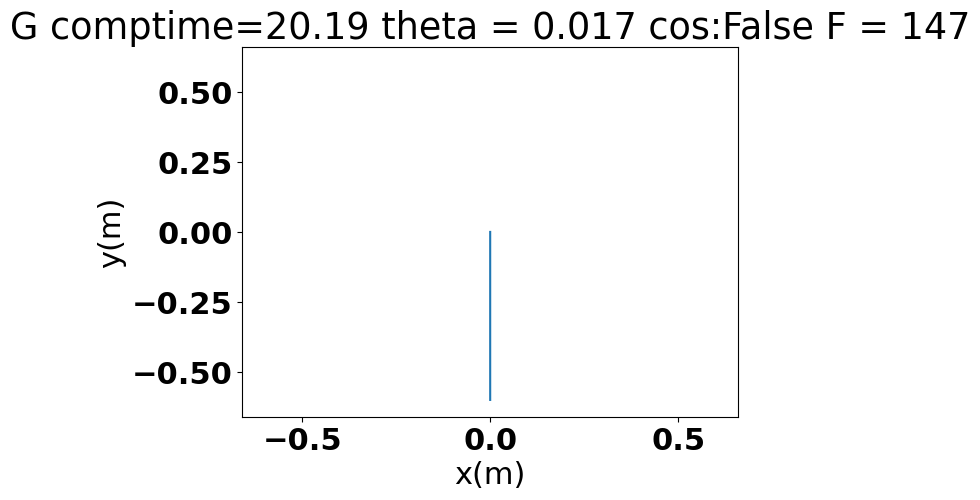

C:\Users\bgs\AppData\Local\Temp\1\ipykernel_908\643348330.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


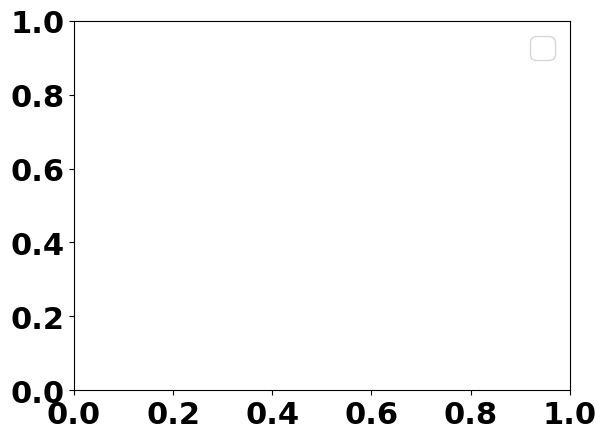

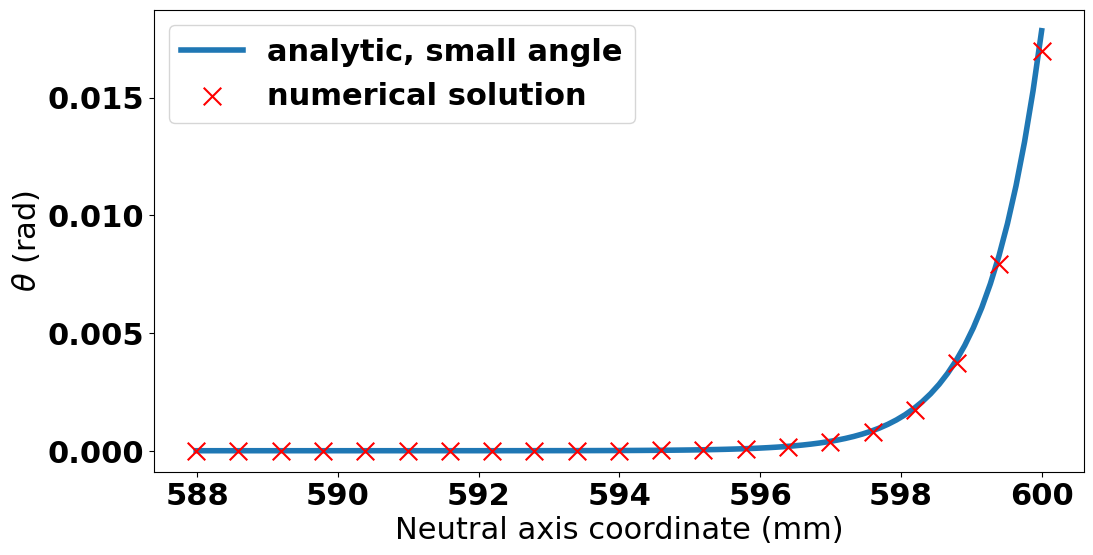

In [21]:
S = np.array(Sa, dtype = "float")
F = np.array(Fa, dtype = "float")
Es = np.array(Esa, dtype = "float")
#print(len(F))
#plt.plot(S,F[:,-2])
#plt.title("Angle over the fiber")
#plt.show()
#plt.title("Error")
#plt.plot(S,Es[:,-2])


xs,zs = integrate_xz([x[1] for x in list(F)],S)
#plot limits to give perceived geometry
lm = [-1.1*np.max([np.max(np.abs(xs)),np.max(np.abs(zs))]),1.1*np.max([np.max(np.abs(xs)),np.max(np.abs(zs))])]

plt.xlim(lm)
plt.ylim(lm)
plt.plot(xs,zs)
#Small total angle error and tolerance for end angle met?
PASSED = np.sum(np.abs(Es[:,-2])) < thet * tol and  np.sum(np.abs(Es[:,-2])) < 0.015 and np.abs(F[-1,-2] - mpmathify(thet))/ mpmathify(thet) < tol

T += (Tf-Ti)/10**9
N +=1
if PASSED:
    N_Passed += 1
    PASSED = "G"
else:
    PASSED = "X"
plt.title(PASSED+ " comptime="+str(round((Tf-Ti)/10**9,2))+" theta = " + str(round(F[-1][-2],5)) + " cos:" + str(cos) + " F = " + str(round(Fs)) )
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.show()

FLOG =((Faa)[1:,1])#)ov( mp.ln,
#print(FLOG)

def linear_model(S, intercept):
    return np.sqrt(If(np.array([0.5]))[0]**-1 * 9.81*15 /73/10**9) * S + intercept

# Perform curve fitting to find intercept
popt, _ = curve_fit(linear_model, S[1:], ov(mp.ln,FLOG[:]), p0=[0])  # Initial guess for intercept = 0
cfit = popt[0]
#plt.ylim(0,0.0001)



plt.legend()
plt.show()
plt.figure(figsize=(12,6))
plt.title("")
plt.ylabel(r"$\theta$ (rad)")
plt.xlabel("Neutral axis coordinate (mm)")
plt.plot(1000*np.linspace(S[979],0.6,100),np.exp((np.sqrt(If(np.array([0.5]))[0]**-1 * 9.81*15 /73/10**9)) * np.linspace(S[979],0.6,100)+cfit), label = "analytic, small angle",linewidth = 4,zorder = -100)
plt.scatter(1000*S[979::1],FLOG[978::1],label=("numerical solution"), c = 'r', s= 160, marker = 'x',zorder = 100)

np.savetxt("numerical_s_small_angle.txt",S[979::1])
np.savetxt("numerical_theta_small_angle.txt",FLOG[978::1])

np.savetxt("analytic_s_small_angle.txt",np.linspace(S[979],0.6,100))
np.savetxt("analytic_theta_small_angle.txt",np.exp((np.sqrt(If(np.array([0.5]))[0]**-1 * 9.81*15 /73/10**9)) * np.linspace(S[979],0.6,100)+cfit))

#plt.scatter(S,np.log(F[:,2]))


plt.legend()
plt.savefig("methods_comparison_small_angle.png")
plt.show()


In [22]:
print(N, N_Passed, "in ", T / N," average time (s) per bend")

1001 1 in  0.02016894715284715  average time (s) per bend


In [23]:
np.linspace(S[979],0.6,100)

array([0.58798799, 0.58810932, 0.58823065, 0.58835199, 0.58847332,
       0.58859466, 0.58871599, 0.58883732, 0.58895866, 0.58907999,
       0.58920132, 0.58932266, 0.58944399, 0.58956532, 0.58968666,
       0.58980799, 0.58992932, 0.59005066, 0.59017199, 0.59029332,
       0.59041466, 0.59053599, 0.59065732, 0.59077866, 0.59089999,
       0.59102132, 0.59114266, 0.59126399, 0.59138532, 0.59150666,
       0.59162799, 0.59174933, 0.59187066, 0.59199199, 0.59211333,
       0.59223466, 0.59235599, 0.59247733, 0.59259866, 0.59271999,
       0.59284133, 0.59296266, 0.59308399, 0.59320533, 0.59332666,
       0.59344799, 0.59356933, 0.59369066, 0.59381199, 0.59393333,
       0.59405466, 0.59417599, 0.59429733, 0.59441866, 0.59453999,
       0.59466133, 0.59478266, 0.59490399, 0.59502533, 0.59514666,
       0.595268  , 0.59538933, 0.59551066, 0.595632  , 0.59575333,
       0.59587466, 0.595996  , 0.59611733, 0.59623866, 0.59636   ,
       0.59648133, 0.59660266, 0.596724  , 0.59684533, 0.59696

In [24]:
theta_test = [1]

cos_test = [False]
F_test = [1]

N = 0
T = 0
N_Passed = 0
thet = theta_test[0]
cos =False
Fs = F_test[0]

#Cosine only bending demo
tol =  mpmathify(0.001)
Sf = mpmathify(0.03)  #600mm
S = mpmathify(0.03)
E = mpmathify("131E9")
#To find a bending of angle theta:
#If F is zero, do a search on F2
#If F is nonzero and F2 is zero do a search on M0
#If both F and F2 are nonzero do a search on F2


N = 1000
#Define geometry of the flexure

#smallest width
mini = 0.005
m=0.015
l = 0.0001
b = 0.01
a = 140
#Define geometry of the flexure
def If(s):
    w = s-m
    return ((1+b-1/(1+np.exp(w/l-a))/(1+np.exp(-w/l-a)))*10**-3)**3  * 10**-4/12 #((s - 0.005)**2/ ((0.005**(2))) + mini)**3 * ((1*10**-3)**3 * 10**-4/12) #* np.exp(np.sin(2/0.01 * 13 * s))

def I(s):
    return mpmathify(If(float(s)))

grid = mp.matrix(np.linspace(0,Sf,N))
#print(grid)
#print(grid[len(grid) - 1],"GRID last entry")
Isamples = mp.matrix(If(np.linspace(0,float(Sf)+0.0,N)))
#floating precision
mp.dps = 40



Ti = time.time_ns()
Sa, Fa, Esa = bend_samples(grid, Isamples, order = 4, E = E, Fsin = mpmathify(Fs), Fcos = cos, theta0 = mpmathify(thet), tol = tol)
Tf = time.time_ns()




using anderson method
m: 0.244329130201507212121
x:     2.9586430820372642662e-354
error: 1.63200395649822647511e-353
m: 0.275222551024382208931
x:     4.59609439453522714673e-355
error: 5.91728616407452853239e-354
m: 0.5
x:     3.00031473143035399444e-356
error: 9.19218878907045429345e-355
m: 0.5
x:     4.61498373624778524168e-358
error: 6.00062946286070798889e-356
m: 0.5
x:     4.65053473565758140751e-358
error: 9.22996747249557048337e-358
m: 0.5
x:     1.4801554570877451929e-358
error: 9.15886547367597815172e-358
m: 0.921822387356417026555
x:     1.0486944116894618727e-358
error: 2.8181069165363057225e-358
[1.04869441168946e-358]
[                  0.0]
[                  0.0] True False


In [25]:
S = np.array(Sa, dtype = "float")
F = np.array(Fa, dtype = "float")
Es = np.array(Esa, dtype = "float")
#print(len(F))
#plt.plot(S,F[:,-2])
#plt.title("Angle over the fiber")
#plt.show()


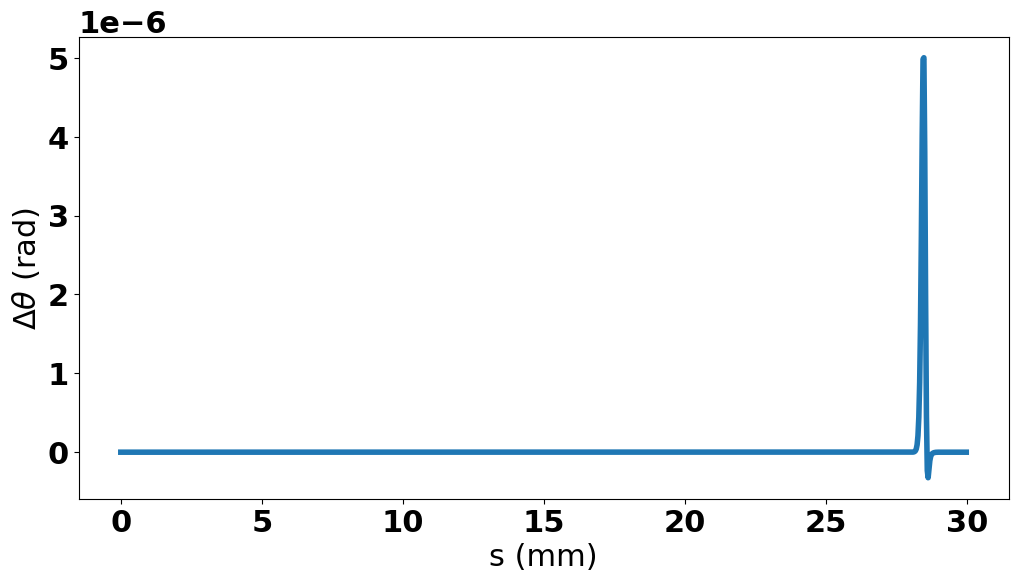

[ 2.51894438e-15  1.92457416e-15  1.45853250e-15  1.09974194e-15
  8.22531355e-16  6.24890722e-16  4.29803152e-16  4.56383787e-16
 -1.70224823e-16  1.77755677e-15]


In [26]:
plt.figure(figsize=(12,6))
plt.plot(1000*S,Es[:,1],linewidth = 4)
plt.xlabel("s (mm)")
plt.ylabel(r"$\Delta \theta$ (rad)")
np.savetxt("B_ribbon_error_radian.txt", Es[:,1])
np.savetxt("B_S_meters_ribbon.txt",S)
plt.savefig("error_ribbon.png")
plt.show()
print(Es[-10:,1])


1.04869441168946e-358 M0


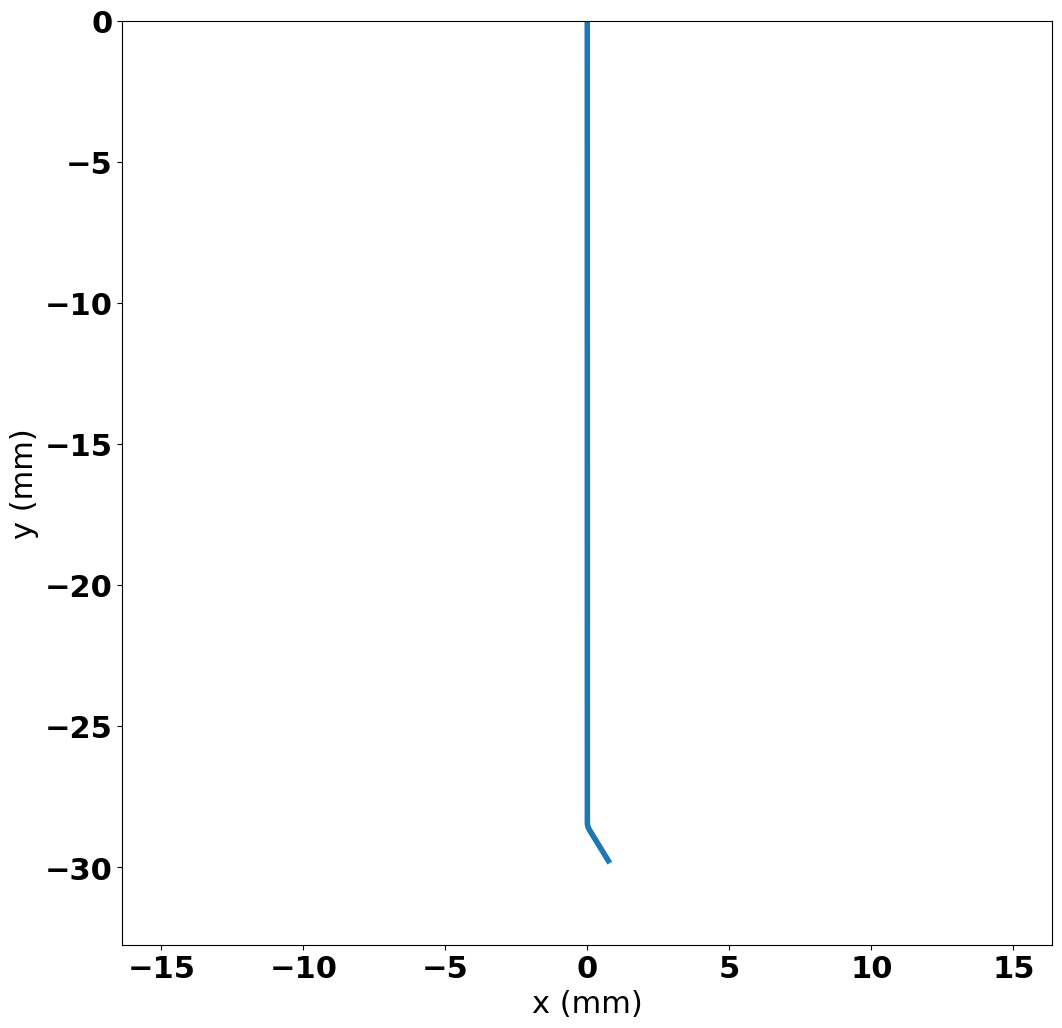

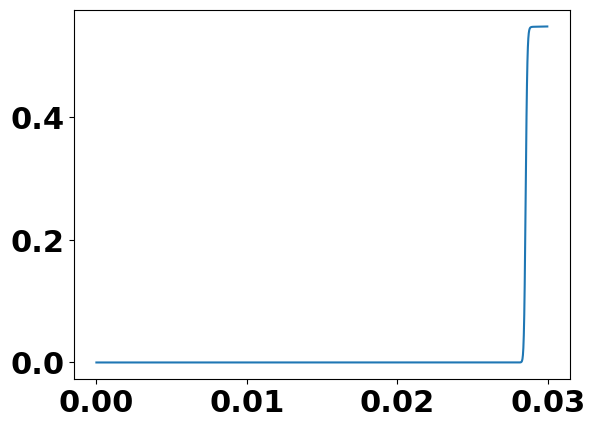

In [27]:

xs,zs = integrate_xz([x[1] for x in list(F)],S)
#plot limits to give perceived geometry
lm = [-1100*np.max([np.max(np.abs(xs)),np.max(np.abs(zs))]),1100*np.max([np.max(np.abs(xs)),np.max(np.abs(zs))])]
print(Fa[0][0],"M0")

plt.figure(figsize=(12,12))
plt.xlim(lm[0]*0.5,lm[1]*0.5)
plt.ylim((lm[0],0 * lm[1]))

plt.plot(1000*xs,1000*zs,linewidth = 4)


#Small total angle error and tolerance for end angle met?
PASSED = np.sum(np.abs(Es[:,-2])) < thet * tol and  np.sum(np.abs(Es[:,-2])) < 0.015 and np.abs(F[-1,-2] - mpmathify(thet))/ mpmathify(thet) < tol

T += (Tf-Ti)/10**9
N +=1
if PASSED:
    N_Passed += 1
    PASSED = "G"
else:
    PASSED = "X"
#plt.title(PASSED+ " comptime="+str(round((Tf-Ti)/10**9,2))+" theta = " + str(round(F[-1][-2],5)) + " cos:" + str(cos) + " F = " + str(round(Fs)) )
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
np.savetxt("C_xs_meters_ribbon.txt", xs)
np.savetxt("C_ys_meters_ribbon.txt",zs)
plt.savefig("bending_ribbon.png")
plt.show()

plt.plot(S,F[:,1])

plt.show()


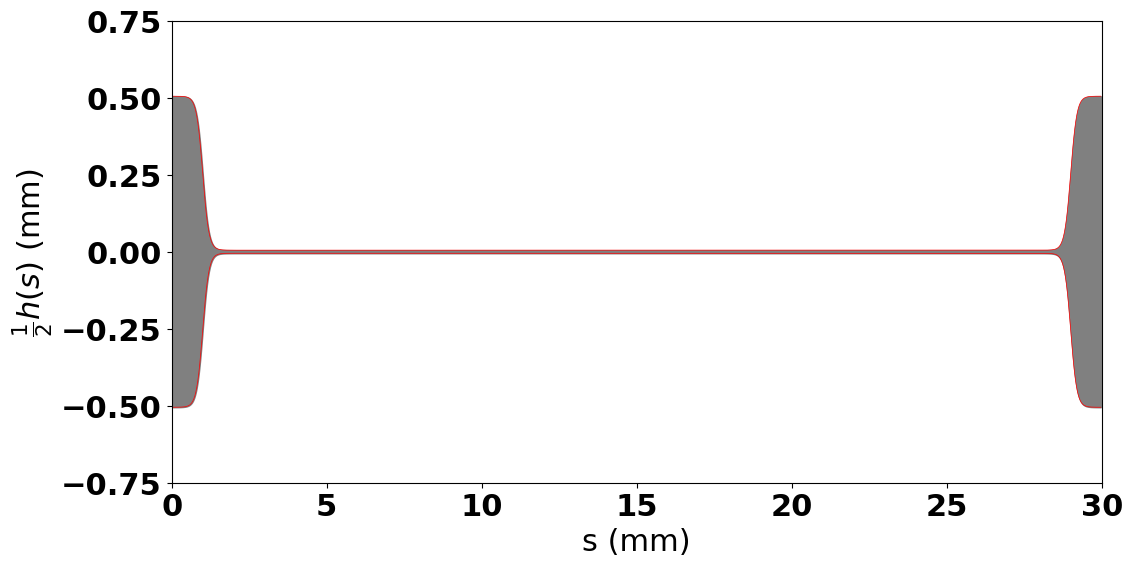

In [28]:

plt.figure(figsize=(12,6))
np.savetxt("A_S_meters_ribbon.txt",S)
np.savetxt("A_half_width_meters_ribbon.txt",((S - 0.005)**2/ ((0.005**(2))) + mini) * (1*10**-3)/2)
w = S - m
plt.plot(S*1000,1000*((1+b-1/(1+np.exp(w/l-a))/(1+np.exp(-w/l-a)))*10**-3)/2,c='r',linewidth = 0.51)
plt.fill_between(S*1000,1000*((1+b-1/(1+np.exp(w/l-a))/(1+np.exp(-w/l-a)))*10**-3)/2, color = 'grey')
plt.plot(S*1000,1000*-((1+b-1/(1+np.exp(w/l-a))/(1+np.exp(-w/l-a)))*10**-3)/2,c='r',linewidth = 0.51)
plt.fill_between(S*1000,-1000*((1+b-1/(1+np.exp(w/l-a))/(1+np.exp(-w/l-a)))*10**-3)/2, color = 'grey')
plt.xlabel("s (mm)")
plt.ylabel(r"$\frac{1}{2}h(s)$ (mm)")
plt.xlim(0,30)
plt.ylim(-.75,.75)
plt.savefig("ribbon.png")
plt.show()

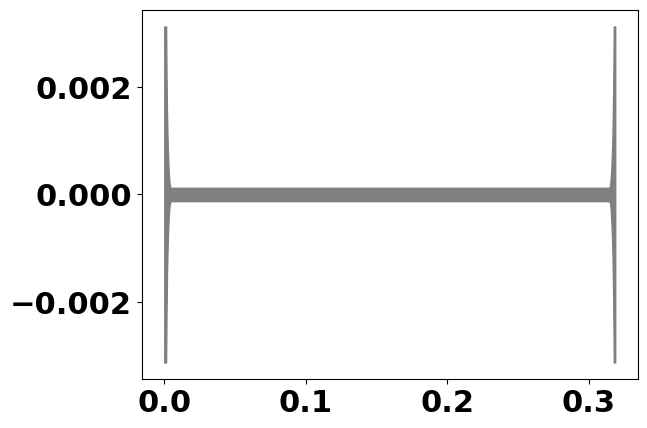

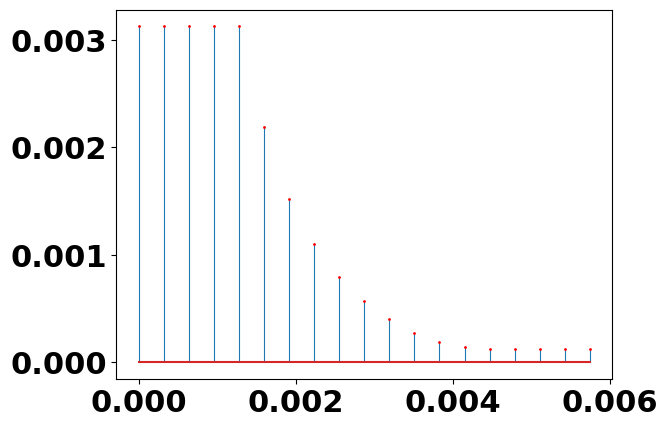

In [101]:
import numpy as np
import matplotlib.pyplot as plt
R = 3 * 10**-3
def h(s):

    ret = s * 1.0
    ret[s < 1.448 * 10**-3] = R + .125 * 10**-3
    ret[np.logical_and(s >= 1.448 * 10**-3, s < 4.448 * 10**-3)] =  R- np.sqrt(R**2 - (R-s[np.logical_and(s >= 1.448 * 10**-3, s < 4.448 * 10**-3)] + 1.448 * 10**-3)**2) + .125 * 10**-3
    ret[np.logical_and(s >= 4.448 * 10**-3, s <  4.448 * 10**-3+310*10**-3)] = .125 * 10**-3
    ret[np.logical_and(s >=  4.448 * 10**-3+310*10**-3, s <  4.448 * 10**-3+310*10**-3 + R)] =  R- np.sqrt(R**2 - (-4.448 * 10**-3-310*10**-3+s[np.logical_and(s >=  4.448 * 10**-3+310*10**-3, s <  4.448 * 10**-3+310*10**-3 + R)])**2) + .125 * 10**-3
    ret[s >=  4.448 * 10**-3+310*10**-3 + R] = R + .125 * 10**-3
    return ret
B= 0.0635 * 10**-3
def If(s):
    return B * h(s)**3 / 12

def I(s):
    return mpmathify(If(float(s)))
Ed = 4.448 * 10**-3+310*10**-3 + R + 1.448 * 10**-3
#Ed = 6 * 10**-3
En = Ed#6 * 10**-3
s = np.linspace(0,Ed,1000)
plt.fill_between(s[s < En],h(s[s < En]), color = 'grey')
plt.fill_between(s[s < En],-h(s[s < En]), color = 'grey')
plt.show()

En = 6 * 10**-3
s = np.linspace(0,Ed,1000)
markerline, stemlines, baseline = plt.stem(s[s<En], h(s[s<En]),markerfmt = 'ro')
stemlines.set_linewidth(0.8)

# Set marker size
markerline.set_markersize(1)

plt.show()

In [102]:
theta_test = [3]

cos_test = [False]
F_test = [1]

N = 0
T = 0
N_Passed = 0
thet = theta_test[0]
cos =False
Fs = F_test[0]

#Cosine only bending demo
tol =  mpmathify(0.001)
Sf = mpmathify( 4.448 * 10**-3+310*10**-3 + R + 1.448 * 10**-3)  #600mm
S = mpmathify( 4.448 * 10**-3+310*10**-3 + R + 1.448 * 10**-3)
E = mpmathify("131E9")
#To find a bending of angle theta:
#If F is zero, do a search on F2
#If F is nonzero and F2 is zero do a search on M0
#If both F and F2 are nonzero do a search on F2


N = 1000
#Define geometry of the flexure

#smallest width



grid = mp.matrix(np.linspace(0,Sf,N))
#print(grid)
#print(grid[len(grid) - 1],"GRID last entry")
Isamples = mp.matrix(If(np.linspace(0,float(Sf)+0.0,N)))
#floating precision
mp.dps = 40



Ti = time.time_ns()
Sa, Fa, Esa = bend_samples(grid, Isamples, order = 4, E = E, Fsin = mpmathify(Fs), Fcos = cos, theta0 = mpmathify(thet), tol = tol)
Tf = time.time_ns()


using anderson method
m: 0.00159399136417184155753
x:     3.6633550465214448795e-116
error: 1.53541476927095060074e-115
m: 0.749507417594136231725
x:     5.33037149718194408819e-119
error: 7.32671009304288975901e-116
m: 0.749507417594136231725
x:     5.35351131625551738279e-119
error: 1.06607429943638881764e-118
m: 0.749507417594136231725
x:     4.20432068901202170943e-119
error: 1.06144633562167415872e-118
m: 0.605319492463398841715
x:     3.74646863461769770956e-119
error: 8.31608210172975024047e-119
m: 0.605319492463398841715
x:     7.17041586530860167538e-119
error: 7.40037799294110224074e-119
m: 0.605319492463398841715
x:     6.90020112807078540029e-119
error: 5.52483531559294309086e-120
m: 0.999199158181811715248
x:     6.89998260006818583583e-119
error: 1.20540570836617588982e-121
[6.89998260006819e-119]
[                  0.0]
[                  0.0] True False


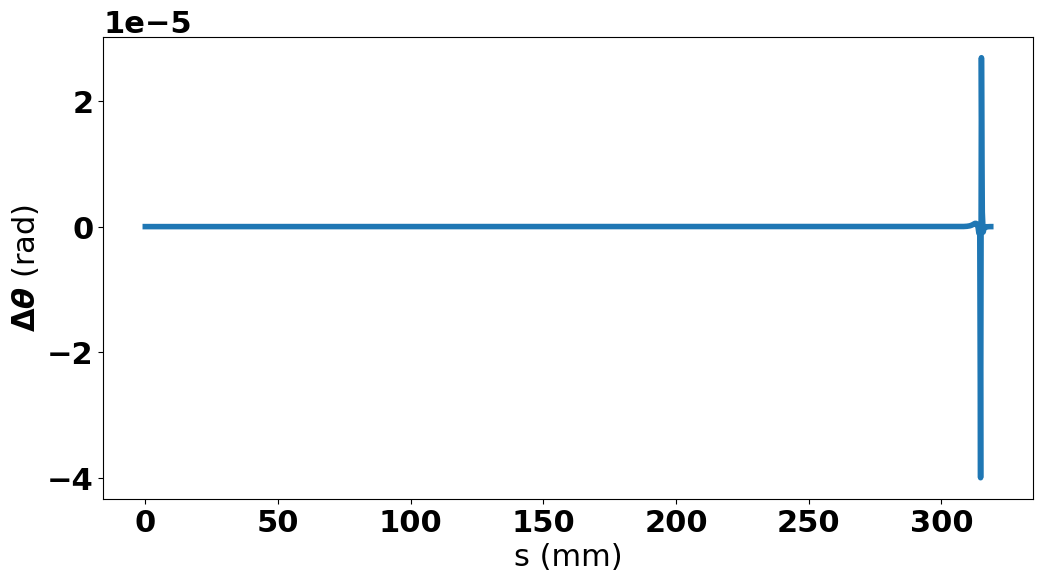

[-8.79360244e-07 -3.38878844e-07 -1.08211844e-07 -9.45721947e-08
 -1.32703350e-08 -2.40025492e-08 -1.29552432e-08 -1.18498787e-10
 -3.91764391e-11  5.86519807e-12]


In [103]:
S = np.array(Sa, dtype = "float")
F = np.array(Fa, dtype = "float")
Es = np.array(Esa, dtype = "float")
#print(len(F))
#plt.plot(S,F[:,-2])
#plt.title("Angle over the fiber")
#plt.show()
plt.figure(figsize=(12,6))
plt.plot(1000*S,Es[:,1],linewidth = 4)
plt.xlabel("s (mm)")
plt.ylabel(r"$\Delta \theta$ (rad)")
np.savetxt("B_ribbon_error_radian.txt", Es[:,1])
np.savetxt("B_S_meters_ribbon.txt",S)
plt.savefig("error_ribbon.png")
plt.show()
print(Es[-10:,1])


6.89998260006819e-119 M0


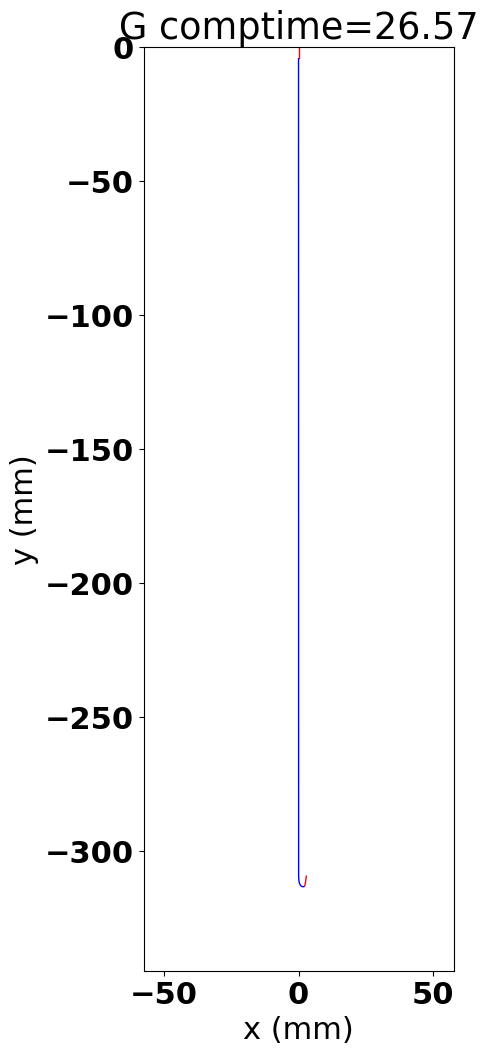

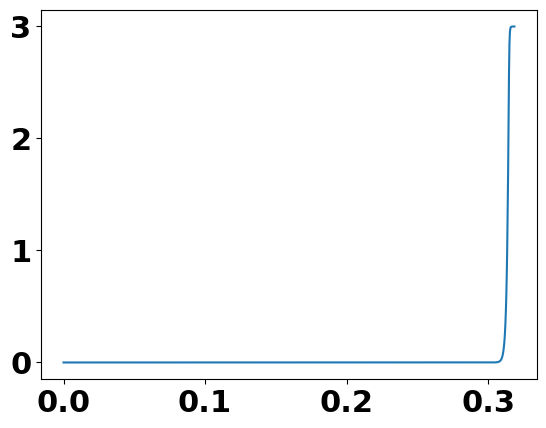

In [110]:

xs,zs = integrate_xz([x[1] for x in list(F)],S)
sp=  s[:-1]

#plot limits to give perceived geometry
lm = [-1100*np.max([np.max(np.abs(xs)),np.max(np.abs(zs))]),1100*np.max([np.max(np.abs(xs)),np.max(np.abs(zs))])]
print(Fa[0][0],"M0")

plt.figure(figsize=(4,12))
plt.xlim(lm[0]*0.5/3,lm[1]*0.5/3)
plt.ylim((lm[0],0 * lm[1]))

plt.plot(1000*xs[sp <  4.448 * 10**-3],1000*zs[sp <  4.448 * 10**-3],linewidth = 1, c = 'r')
plt.plot(1000*xs[(sp >  310*10**-3 + 4.448 * 10**-3)],1000*zs[(sp >  310*10**-3 + 4.448 * 10**-3)],linewidth = 1, c = 'r')
plt.plot(1000*xs[np.logical_and(sp >  4.448 * 10**-3,sp <= 310*10**-3 + 4.448 * 10**-3)],1000*zs[np.logical_and(sp >  4.448 * 10**-3,sp <=  310*10**-3 + 4.448 * 10**-3)],linewidth = 1, c = 'b')

#Small total angle error and tolerance for end angle met?
PASSED = np.sum(np.abs(Es[:,-2])) < thet * tol and  np.sum(np.abs(Es[:,-2])) < 0.015 and np.abs(F[-1,-2] - mpmathify(thet))/ mpmathify(thet) < tol

T += (Tf-Ti)/10**9
N +=1
if PASSED:
    N_Passed += 1
    PASSED = "G"
else:
    PASSED = "X"
plt.title(PASSED+ " comptime="+str(round((Tf-Ti)/10**9,2)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
np.savetxt("C_xs_meters_ribbon.txt", xs)
np.savetxt("C_ys_meters_ribbon.txt",zs)
plt.savefig("bending_ribbon.png")
plt.show()

plt.plot(S,F[:,1])

plt.show()
